In [2]:
import sys
main_path = "../.."
sys.path.append(main_path)

import numpy as np
import pandas as pd
from impyute.imputation.cs import fast_knn
import os
import yaml
import copy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from src.scripts.model_and_evaluation import ModelAndEvaluation
from src.scripts.extra_features_model_and_evaluation import ExtraFeaturesModelAndEvaluation
import seaborn as sns
from src.scripts.common_figures import Figures
import itertools


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/Versi

In [3]:
figures = Figures()
sns.set_context('poster', font_scale=0.8)

In [15]:
model_and_evaluation = ModelAndEvaluation()
extra_featues_modal_and_evaluation = ExtraFeaturesModelAndEvaluation()

In [5]:
df_path = f"{main_path}/data/processed/dataframes"
xlsx_lung = pd.ExcelFile('../../data/raw/lung_cancer.xlsx')

# Sayfa adlarını yazdırın
df1_lung = pd.read_excel(xlsx_lung, sheet_name='akciğer')
df2_lung = pd.read_excel(xlsx_lung, sheet_name='kontrol')

df1_lung = df1_lung.iloc[:][3:len(df1_lung)]
df2_lung = df2_lung.iloc[:][3:len(df2_lung)]


xlsx_lung = pd.ExcelFile('../../data/raw/colon_cancer.xlsx')

# Sayfa adlarını yazdırın
df1_colon = pd.read_excel(xlsx_lung, sheet_name='Sayfa1')
# df2_lung = pd.read_excel(xlsx_lung, sheet_name='kontrol')

df1_colon = df1_colon.iloc[:][3:len(df1_colon)]

# data = data.iloc[:][3:len(data)]
lung_cancer_columns = ['IDO-1', 'p16540', 'p16580', 'FOXP3', 'ICAM-1', 'GALECTİN-3', 'CD27', 'PD1/pdcd1PDL1/cd274', 'PDL1', 'CD40', 'TIM1','CTLA-4', 'MDM2']
colon_cancer_columns = ['p16540', 'p16580', 'mdm2', 'GAL3', 'TIM1', 'trail', 'pd1duz', 'pdl1poly', 'CD28', 'cd27snp','CD40']
common_columns_colon = ['p16540', 'p16580', 'mdm2', 'GAL3', 'TIM1', 'cd27snp', 'CD40','pd1duz', 'pdl1poly', 'CD28']
common_columns_lung = ['p16540', 'p16580', 'MDM2', 'GALECTİN-3', 'TIM1', 'CD27', 'CD40','PD1/pdcd1PDL1/cd274', 'PDL1', 'CD28']

target_lung = df1_lung["Unnamed: 9"]
target_lung_control = df2_lung["Unnamed: 5"]
target_lung = np.where(target_lung == 'kontrol', 0, 1)
target_lung_control = np.where(target_lung_control == 'kontrol', 0, 1)
target_lung = np.concatenate([target_lung, target_lung_control])

target_colon = np.ravel(df1_colon.iloc[:,0])
target_colon = np.where(target_colon == 'kontrol', 0, 2)
# lung_cancer_columns = ["IDO-1", ""]
# print(df1_colon[common_columns_colon])

total_target = np.concatenate([target_lung, target_colon])

data_lung_cancer = pd.concat([df1_lung[common_columns_lung], df2_lung[common_columns_lung]])
data_colon_cancer = df1_colon[common_columns_colon]
total_data = pd.concat([data_lung_cancer, data_colon_cancer])

print(pd.DataFrame(total_data))





pd.DataFrame(total_target, columns=['target']).to_csv(f"{df_path}/total_targets.csv", index=False)
# targets = np.where(targets == 'kontrol', 0, 1)


    p16540 p16580 MDM2 GALECTİN-3 TIM1 CD27 CD40 PD1/pdcd1PDL1/cd274 PDL1   
3       CC     CC   TT         AC   CC   TT   CC                  CT   AA  \
4       CC     CC   TG         CC   GC   AA   CC                  CC   AC   
5       CG     CC   TG         AA   CC   AA   CC                  CT   AC   
6      NaN    NaN  NaN         AC   GC   AA   CT                  CT   AC   
7       CC     CC   TG        NaN   CC   AT   CT                  CT   AC   
..     ...    ...  ...        ...  ...  ...  ...                 ...  ...   
112     GC     CC  NaN        NaN   GG  NaN  NaN                 NaN  NaN   
113     CC     CC  NaN        NaN   GG  NaN  NaN                 NaN  NaN   
114     CC     CC  NaN        NaN   GC  NaN  NaN                 NaN  NaN   
115     GC     CT  NaN        NaN   GG  NaN  NaN                 NaN  NaN   
116     GC     CT  NaN        NaN   GC  NaN  NaN                 NaN  NaN   

    CD28 mdm2 GAL3 cd27snp pd1duz pdl1poly  
3     TT  NaN  NaN     NaN    

CDT_DI_FI_OHE

In [6]:
with open(f'{main_path}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
decimal_forms = config['decimal']

In [7]:
cdt = pd.DataFrame(total_data)
cdt.columns = total_data.columns

for col in cdt.columns:
    cdt[col] = cdt[col].map(decimal_forms)

print(cdt.values)

[[10. 10.  5. ... nan nan nan]
 [10. 10. nan ... nan nan nan]
 [nan 10. nan ... nan nan nan]
 ...
 [10. 10. nan ... nan  9.  2.]
 [14.  9. nan ...  1. 10. nan]
 [14.  9. nan ... nan nan nan]]


In [8]:
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

print(cdt)

cdt_di = fast_knn(cdt.values, k=30)

cdt_di_df = pd.DataFrame(cdt_di, columns=cdt.columns)
cdt_di_df.to_csv(f"{df_path}/cdt_di_total.csv", index=False)

     p16540  p16580  MDM2  GALECTİN-3  TIM1  CD27  CD40  PD1/pdcd1PDL1/cd274   
3      10.0    10.0   5.0         2.0  10.0   5.0  10.0                  9.0  \
4      10.0    10.0   NaN        10.0  14.0   0.0  10.0                 10.0   
5       NaN    10.0   NaN         0.0  10.0   0.0  10.0                  9.0   
6       NaN     NaN   NaN         2.0  14.0   0.0   9.0                  9.0   
7      10.0    10.0   NaN         NaN  10.0   1.0   9.0                  9.0   
..      ...     ...   ...         ...   ...   ...   ...                  ...   
112    14.0    10.0   NaN         NaN  15.0   NaN   NaN                  NaN   
113    10.0    10.0   NaN         NaN  15.0   NaN   NaN                  NaN   
114    10.0    10.0   NaN         NaN  14.0   NaN   NaN                  NaN   
115    14.0     9.0   NaN         NaN  15.0   NaN   NaN                  NaN   
116    14.0     9.0   NaN         NaN  14.0   NaN   NaN                  NaN   

     PDL1  CD28  mdm2  GAL3  cd27snp  p

In [9]:
cdt_di_fi = np.round(cdt_di).astype('int')
cdt_di_fi_df = pd.DataFrame(cdt_di_fi, columns=cdt.columns)
cdt_di_fi_df.to_csv(f"{df_path}/cdt_di_fi_total.csv", index=False)

In [10]:
cdt_di_ohe_df = pd.get_dummies(cdt_di_df, sparse=True, columns=cdt.columns)
cdt_di_ohe_df.to_csv(f"{df_path}/cdt_di_ohe_total.csv", index=False)

In [11]:
cdt_di_fi_ohe_df = pd.get_dummies(cdt_di_fi_df.astype('str'), sparse=True, columns=cdt.columns)

cdt_di_fi_ohe_df.to_csv(f"{df_path}/cdt_di_fi_ohe_total.csv", index=False)

In [18]:
cdt_di_fi_ohe_total = pd.read_csv(f"{df_path}/cdt_di_fi_ohe_total.csv")
total_targets = pd.read_csv(f"{df_path}/total_targets.csv").values.ravel()

metrics_score_cdt_di_fi_ohe = extra_featues_modal_and_evaluation.regression_model(cdt_di_fi_ohe_total.values, total_targets)
print(metrics_score_cdt_di_fi_ohe)


{'lr': {'f1': [0.7287625418060201, 0.7716962524654831, 0.8100591715976331, 0.6013986013986015, 0.7989898989898989, 0.7165384615384616, 0.8397202797202796, 0.7517142857142858, 0.7168820512820511, 0.674]}, 'rf': {'f1': [0.7605769230769232, 0.8071005917159764, 0.7731643356643356, 0.7346745562130177, 0.7066833855799373, 0.72, 0.8382657342657341, 0.7123809523809524, 0.6701298701298701, 0.9186666666666667]}, 'svm': {'f1': [0.6237672583826429, 0.8089743589743589, 0.808974358974359, 0.648721967687485, 0.7117742946708464, 0.6854545454545454, 0.8381538461538461, 0.7954285714285715, 0.7429450549450549, 0.84]}}


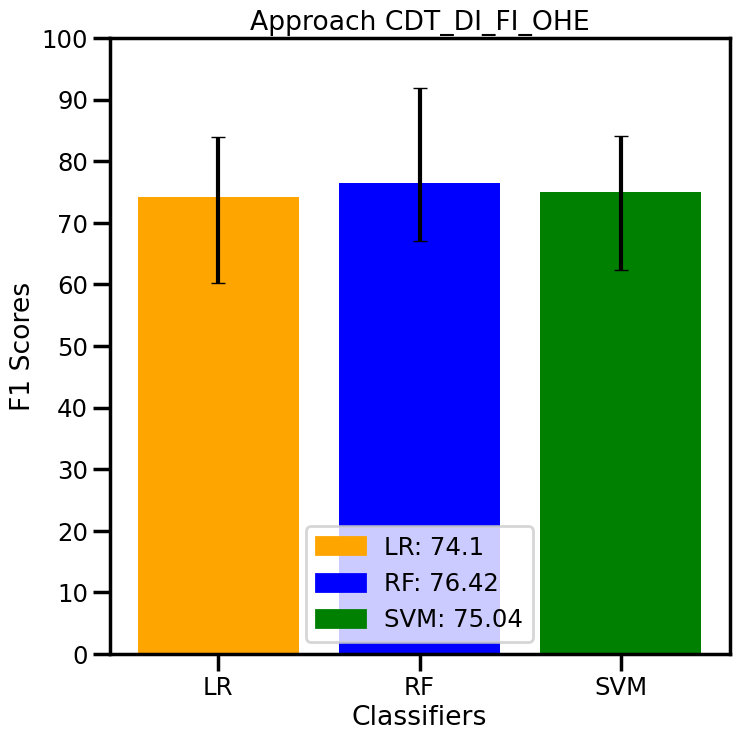

In [20]:
class_names = {'cdt_di_fi_ohe':'Approach CDT_DI_FI_OHE'}

classifier_names = ['LR', 'RF', 'SVM']

scores = { 'cdt_di_fi_ohe':[metrics_score_cdt_di_fi_ohe[i.lower()]['f1'] for i in classifier_names]}

save = f"{main_path}/figures/paper_figures/png/f1scores_cdt_di_fi_ohe_total.png"
paper_figure = f"{main_path}/figures/paper_figures/svg/da.svg"
figures.draw_bar_plot(classifier_names, scores, class_names, grid_shape=(1, 1), save=save, paper_figure=paper_figure)
